In [1]:
import os
import sys
from copy import deepcopy

project_dir = os.path.dirname(os.getcwd())
print(project_dir)
sys.path.append(project_dir)

import matplotlib.pyplot as plt
import numpy as np
from omegaconf import OmegaConf


import torch
from torchvision.transforms import ToPILImage, ToTensor, Normalize
from training.dataset.transforms import ComposeAPI, NormalizeAPI
from tqdm import tqdm

from helpers.configurations import TRACK_TO_METAINFO
from dataset.collate_fn import collate_fn
from dataset.mini_dataset import MiniDataset
from debugging.show import *
from custom_model_builder import build_sam2_predict

/home/guests/tuna_gurbuz/prototype


In [2]:
# Dataset
object_labels = [10]
len_video = 1
input_image_size = 512
batch_size = 1
shuffle = False
mean = [0.3551, 0.3500, 0.3469]
std = [0.2921, 0.2716, 0.2742]
transforms = [ComposeAPI([NormalizeAPI(mean=mean, std=std, v2=True)])]
revert_mean=[-.3551/.2921, -.3500/.2716, -.3469/.2742]
revert_std=[1/.2921, 1/.2716, 1/.2742]
revert_transform = Normalize(mean=revert_mean, std=revert_std)
test_dataset = MiniDataset('over_train',
                           num_frames=len_video,
                           input_image_size=input_image_size,
                           object_labels=object_labels,
                           transforms=transforms,
                           collate_fn=collate_fn,
                           batch_size=batch_size,
                           shuffle=shuffle,
                           get_seg_mask=True)
print(f'Lenght of the dataset! {len(test_dataset)}')

Loading the take 001_PKA!



5683it [00:13, 418.59it/s]


Lenght of the dataset! 17049


In [3]:
seed = 123  # Check seed 123 index 19966
torch.manual_seed(seed)
np.random.seed(seed)

len_objects = len(object_labels)
toPILimage = ToPILImage()
iid = 10000

# frame_obj_list, frames_segmentation_mask = test_dataset[idx]
# image = frame_obj_list.frames[0].data

In [4]:
len_data = len(test_dataset)
print(f'Length of the dataset: {len_data}')

# OLD SLICE
# camera_switch = (len_data//3, 2*len_data//3)
# print(test_dataset.images[0], '\n', test_dataset.images[camera_switch[0]-1], '\n', test_dataset.images[camera_switch[0]])

# NEW SLICE
print(test_dataset.images[0], '\n',test_dataset.images[1], '\n',test_dataset.images[2])

Length of the dataset: 17049
[PosixPath('/home/polyaxon-data/data1/MM-OR_processed/001_PKA/colorimage/camera01_colorimage-000329.jpg')] 
 [PosixPath('/home/polyaxon-data/data1/MM-OR_processed/001_PKA/colorimage/camera04_colorimage-000329.jpg')] 
 [PosixPath('/home/polyaxon-data/data1/MM-OR_processed/001_PKA/colorimage/camera05_colorimage-000329.jpg')]


In [5]:
# Get the first three images
cam1 = test_dataset.images[iid]
cam4 = test_dataset.images[iid + 1]
cam5 = test_dataset.images[iid + 2]

# Use get item: 0) VideoDataBatch 1) Segmentation mask
cam1_vid = test_dataset[iid][0]
cam4_vid = test_dataset[iid + 1][0]
cam5_vid = test_dataset[iid + 2][0]

# Use first frame
cam1 = cam1_vid.frames[0].data
cam4 = cam4_vid.frames[0].data
cam5 = cam5_vid.frames[0].data

gt_mask1 = cam1_vid.frames[0].objects[0].segment
gt_mask4 = cam4_vid.frames[0].objects[0].segment
gt_mask5 = cam5_vid.frames[0].objects[0].segment

print(gt_mask1.shape)
print(gt_mask1.dtype)

torch.Size([512, 512])
torch.uint8


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].


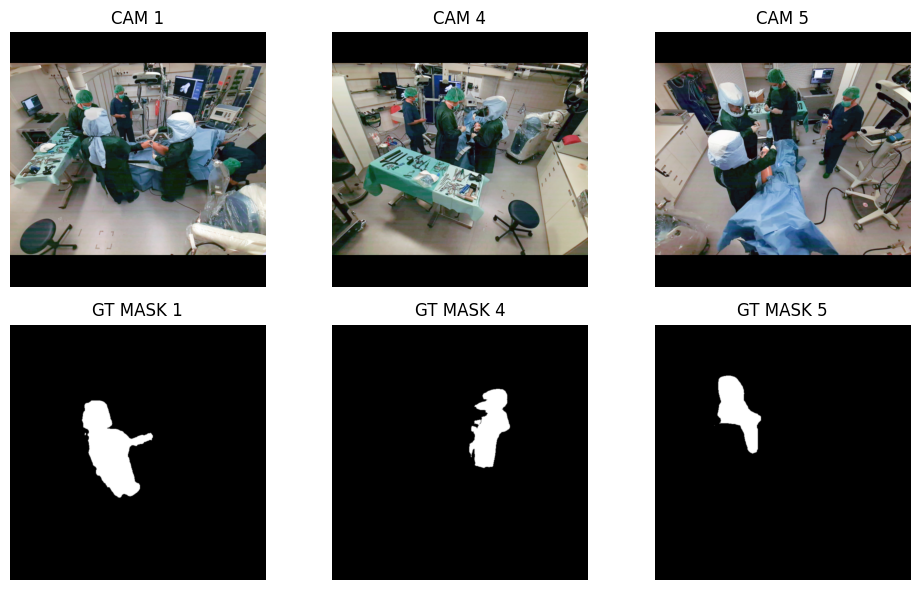

In [6]:
import matplotlib.pyplot as plt

# Create figure and subplots
fig, axes = plt.subplots(2, 3, figsize=(10, 6))

# Transpose from tensor to numpy shape
cam1 = revert_transform(cam1).permute(1,2,0)
cam4 = revert_transform(cam4).permute(1,2,0)
cam5 = revert_transform(cam5).permute(1,2,0)

# First row (RGB, GT, Black Placeholder)
axes[0,0].imshow(cam1)
axes[0,0].set_title("CAM 1")

axes[0,1].imshow(cam4)
axes[0,1].set_title("CAM 4")

axes[0,2].imshow(cam5)
axes[0,2].set_title("CAM 5")

axes[1,0].imshow(gt_mask1, cmap='gray')
axes[1,0].set_title("GT MASK 1")

axes[1,1].imshow(gt_mask4, cmap='gray')
axes[1,1].set_title("GT MASK 4")

axes[1,2].imshow(gt_mask5, cmap='gray')
axes[1,2].set_title("GT MASK 5")

# Remove axes for a cleaner look
for ax in axes.ravel():
    ax.axis('off')

# Show the plot
plt.tight_layout()
plt.show()

In [17]:
is_black_row = (cam1[:,:,0] <= 0)  # Check along width and channels
pos_padding = np.where(is_black_row == False)
start = pos_padding[0][0]
end = pos_padding[0][-1]

# Slice the predictions and ground truth masks
if start == 64:
    cam1 = cam1[start:end+1, :, :]
    cam4 = cam4[start:end+1, :, :]
    cam5 = cam5[start:end+1, :, :]
elif start == 0:
    pass
else:
    raise ValueError("Padding not found in the image")

In [7]:
import os
import json

import cv2
import numpy as np
from scipy.spatial.transform import Rotation

def skew(t):
    return np.array([
        [0, -t[2], t[1]],
        [t[2], 0, -t[0]],
        [-t[1], t[0], 0]
    ])

In [ ]:
def compute_epipolar_lines(F, pts1):
    # pts1: Nx2 array
    pts1_h = np.hstack((pts1, np.ones((pts1.shape[0], 1))))  # homogeneous
    lines2 = (F @ pts1_h.T).T  # Each row is [a, b, c]
    return lines2

def draw_epilines(img2, lines, colors, padding=0):
    h, w = img2.shape[:2]
    for r, color in zip(lines, colors):
        color = color.tolist() if isinstance(color, np.ndarray) else color
        # a, b, c = r
        # x0, x1 = 0, w
        # y0 = int((-c - a * x0) / b)
        # y1 = int((-c - a * x1) / b)
        x0,y0 = map(int, [0, -(r[2])/r[1] - padding])
        x1,y1 = map(int, [w, -(r[2] + r[0]*w)/r[1] - padding])
        img2 = cv2.line(img2, (x0, y0), (x1, y1), color, 2)
    return img2

In [63]:
def sample_project_points_3D(pts, ext, K):
    # pts: Nx2 array
    # ext: 4x4 array
    # K: 3x3 array
    pts_h = np.concatenate((pts, np.ones((pts.shape[0], 1))), axis=1)  # homogeneous
    
    # Depth samples
    depth = [0.1, 2]
    
    # Sample points in the camera coordinate system
    pts3d_close = depth[0] * np.linalg.inv(K) @ pts_h.T
    pts3d_far = depth[1] * np.linalg.inv(K) @ pts_h.T
    pts3d = np.concatenate((pts3d_close, pts3d_far), axis=1)  # 3D points in camera coordinates 3x2N
    pts3d_h = np.concatenate((pts3d, np.ones((1, pts3d.shape[1]))), axis=0)  # homogeneous 4x2N
    
    # Transform to second frame coordinates
    pts3d_transformed = ext @ pts3d_h  # 4x2N
    
    # Reproject to image plane
    pts2d = K @ pts3d_transformed[:3, :]  # 3x2N
    pts2d /= pts2d[2, :]  # Normalize
    pts2d = pts2d[:2, :].T  # Nx2
    return pts2d

def draw_lines_from_points(img, pts_close, pts_far, colors=(0, 255, 0)):
    radius = 3
    for pt_c, pt_f, clr in zip(pts_close, pts_far, colors):
        clr = clr.tolist() if isinstance(clr, np.ndarray) else clr
        pt_c = tuple(map(int, pt_c))
        pt_f = tuple(map(int, pt_f))
        cv2.line(img, pt_c, pt_f, clr, radius)
    return img

In [64]:
def load_camera_data(camera_data, downscale=1):
    h, w = camera_data['value0']['color_parameters']['height'], camera_data['value0']['color_parameters']['width']
    h_, w_ = h // downscale, w // downscale
    # padding = (w_ - h_) // 2
    padding = 0
    intrinsics_json = camera_data['value0']['color_parameters']['intrinsics_matrix']
    K = np.asarray([[intrinsics_json['m00'] / downscale, intrinsics_json['m10'], intrinsics_json['m20'] / downscale],
                    [intrinsics_json['m01'], intrinsics_json['m11'] / downscale, intrinsics_json['m21'] / downscale + padding],
                    [0, 0, 1]])
    # padding = (w_ - h_) // 2
    extrinsics_json = camera_data['value0']['camera_pose']
    trans = extrinsics_json['translation']
    rot = extrinsics_json['rotation']
    extrinsics = np.zeros((4, 4), dtype=np.float32)
    R = Rotation.from_quat([rot['x'], rot['y'], rot['z'], rot['w']]).as_matrix()
    extrinsics[:3, :3] = R
    t = [trans['m00'], trans['m10'], trans['m20'], 1]
    extrinsics[:, 3] = t

    return K, extrinsics, padding

In [65]:
downscale = 4
take_path = '/home/polyaxon-data/data1/MM-OR_processed/001_PKA/'
camera_files = ['camera01.json', 'camera04.json', 'camera05.json']
camera_int_ext = []
for json_file in camera_files:
    with open(os.path.join(take_path, json_file), 'r') as f:
        camera_data = json.load(f)
    intr, ext, padding = load_camera_data(camera_data, downscale)
    camera_int_ext.append((intr, ext))

In [66]:
K0, ext0 = camera_int_ext[0]
K1, ext1 = camera_int_ext[1]

R0, t0 = ext0[:3, :3], ext0[:3, 3]
R1, t1 = ext1[:3, :3], ext1[:3, 3]

# Main computation
ext = ext1 @ np.linalg.inv(ext0)
R, t = ext[:3, :3], ext[:3, 3]

# Sanity Check (works fine)
# R = R1 @ R0.T
# t = t1 - R @ t0
K = K1

In [67]:
pts2.shape, pts2_close.shape, pts2_close
pts2_close[0], tuple(map(int, pts2_close[0])) 

(array([432.82351086, 212.87451803]), (432, 212))

In [68]:
# Define points in image 1
# pts1 = np.array([[100, 100], [150, 150], [200, 200], [256, 256], [300, 300]])
pts1 = np.array([[256, idx] for idx in range(50, 300, 50)])
# pts1 = np.array([[idx, idx] for idx in range(50, 300, 50)])
# pts1 = np.array([[100, 100], [150, 150]])
# pts1 = np.array([[idx, idx] for idx in range(500, 1000, 50)])
# y, x = torch.where(gt_mask1 == 255)
# pts1 = torch.cat([x.unsqueeze(1), y.unsqueeze(1)], dim=1).numpy()

# Define colors for points
num_points = pts1.shape[0]
colors = plt.cm.jet(np.linspace(0, 1, num_points))[:, :3] * 255  # RGB 0-255
colors = colors.astype(np.uint8)

if False:
    # Compute Epipolar Lines
    E = skew(t) @ R
    inv_K = np.linalg.inv(K)
    F = inv_K.T @ E @ inv_K
    lines2 = compute_epipolar_lines(F, pts1)
    # lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1, 1, 2), 1, F).squeeze(1)

    # Draw Epipolar Lines
    # Be aware that l2 @ x2 = 0 so ax + by + c = 0, where (a,b,c) = l2
    img2_with_lines = draw_epilines(cam4.numpy().copy(), lines2, colors, padding=padding)
else:
    # Project Reproject Points
    pts2 = sample_project_points_3D(pts1, ext, K)

    # Draw lines from points
    cf_cut = pts2.shape[0] // 2
    pts2_close = pts2[:cf_cut, :]
    pts2_far = pts2[cf_cut:, :]
    img2_with_lines = draw_lines_from_points(cam4.numpy().copy(), pts2_close, pts2_far, colors=colors)

# Chat GPT This is the epipole 1
# U, D, Vh = np.linalg.svd(E)
# epipole = Vh[-1,:]
# epipole = epipole / epipole[-1]
# epipole_px = K @ epipole

# We know that the epipole 1 is scaled to R.T @ t
# and we know that the epipole 2 is scaled to t
epipole = t
epipole =  epipole / epipole[-1]
epipole_px = K @ epipole

# Draw Epipole
ep_ctr = (np.round(epipole_px[0].astype(int)), np.round(epipole_px[1].astype(int)) - padding)
img2_with_lines = cv2.circle(img2_with_lines, ep_ctr, 4, [0, 255, 0], -1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


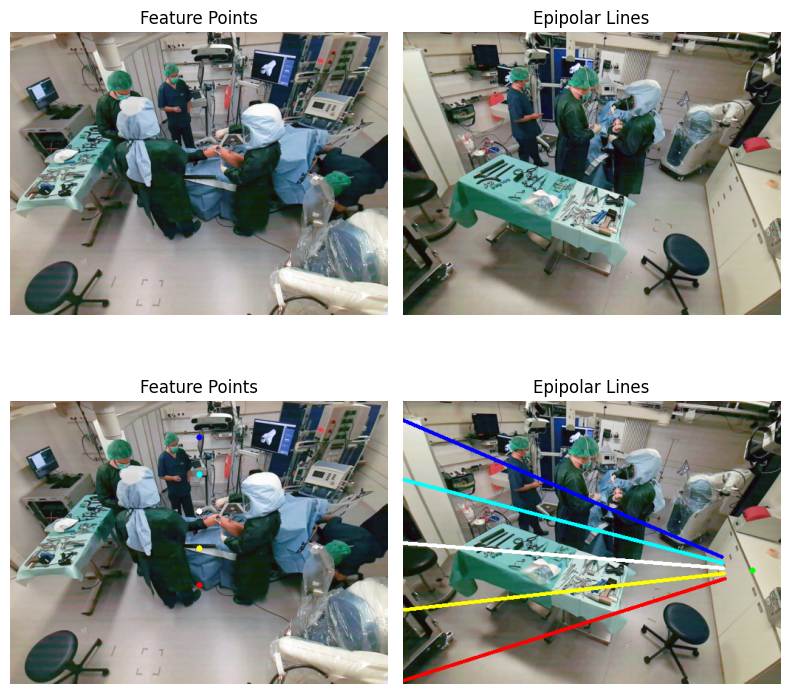

In [69]:
img1_color = cam1.numpy().copy()
for pt, color in zip(pts1, colors):
    pt_int = tuple(np.round(pt).astype(int))
    img1_color = cv2.circle(img1_color, pt_int, 4, color.tolist(), -1)
    
figsize = np.array([8,8])
fig, axs = plt.subplots(2, 2, figsize=figsize, )

axs[0,0].imshow(cam1.numpy().copy())
axs[0,0].axis('off')
axs[0,0].set_title("Feature Points")

axs[0,1].imshow(cam4.numpy().copy())
axs[0,1].axis('off')
axs[0,1].set_title("Epipolar Lines")

axs[1,0].imshow(img1_color)
axs[1,0].axis('off')
axs[1,0].set_title("Feature Points")

axs[1,1].imshow(img2_with_lines)
axs[1,1].axis('off')
axs[1,1].set_title("Epipolar Lines")

plt.tight_layout()
plt.show()

In [70]:
# sift = cv2.SIFT_create()
# test_im1 = (cam1.numpy().copy() * 255).astype(np.uint8)
# test_im4 = (cam4.numpy().copy() * 255).astype(np.uint8)

# gray1 = cv2.cvtColor(test_im1 ,cv2.COLOR_RGB2GRAY)
# gray4 = cv2.cvtColor(test_im4, cv2.COLOR_RGB2GRAY)

# # find the keypoints and descriptors with SIFT
# kp1, des1 = sift.detectAndCompute(gray1, None)
# kp2, des2 = sift.detectAndCompute(gray4, None)
 
# # FLANN parameters
# FLANN_INDEX_KDTREE = 1
# index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
# search_params = dict(checks=50)
 
# flann = cv2.FlannBasedMatcher(index_params,search_params)
# matches = flann.knnMatch(des1,des2,k=2)
 
# pts1 = []
# pts4 = []
 
# # ratio test as per Lowe's paper
# for i,(m,n) in enumerate(matches):
#     if m.distance < 1.0*n.distance:
#         pts4.append(kp2[m.trainIdx].pt)
#         pts1.append(kp1[m.queryIdx].pt)

# best_pts1 = []
# best_pts4 = []

# # Check Epipolar Constraint
# for pt1, pt4 in zip(pts1, pts4):
#     pt1_h = np.array([pt1[0], pt1[1], 1])
#     pt4_h = np.array([pt4[0], pt4[1], 1])
#     epipolar_constraint = np.dot(pt4_h, F @ pt1_h)
#     best_pts1.append(pt1) if np.abs(epipolar_constraint) < 1e-2 else None
#     best_pts4.append(pt4) if np.abs(epipolar_constraint) < 1e-2 else None

# # Override pts1 and pts4 with best points
# pts1 = best_pts1
# pts4 = best_pts4

# # Define colors for points
# num_points = len(pts1)
# colors = plt.cm.jet(np.linspace(0, 1, num_points))[:, :3] * 255  # RGB 0-255
# colors = colors.astype(np.uint8)

# for pt1, pt4, color in zip(pts1, pts4, colors):
#     pt1_int = tuple(np.round(pt1).astype(int))
#     pt4_int = tuple(np.round(pt4).astype(int))
#     test_im1 = cv2.circle(test_im1, pt1_int, 4, color.tolist(), -1)
#     test_im4 = cv2.circle(test_im4, pt4_int, 4, color.tolist(), -1)

In [71]:
# # Display the image with feature points
# plt.imshow(test_im1)
# plt.title("Feature Points 1")
# plt.axis('off')
# plt.show()

# # Display the image with epipolar lines
# plt.imshow(test_im4)
# plt.title("Feature Points 4")
# plt.axis('off')
# plt.show()